In [ ]:
import os,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.spatial as spatial
import seaborn as sns
import math

pd.set_option('max.columns',500)
%matplotlib inline
from IPython.display import Image

# Problema

Controle de potências em uma célula com desvanescimento definido

## Definição do desvanescimento

## Função objetivo

In [ ]:
def fitness_function(p_r):
    p_r = p_r[0]
    if p_r > 3:
        fit = 1*(2 - (2**(-1*p_r+3+1))) - 0.25*p_r
    else:
        fit = 1*(-3 + 1.5*p_r/5)

    return fit

Text(0, 0.5, 'Função objetivo')

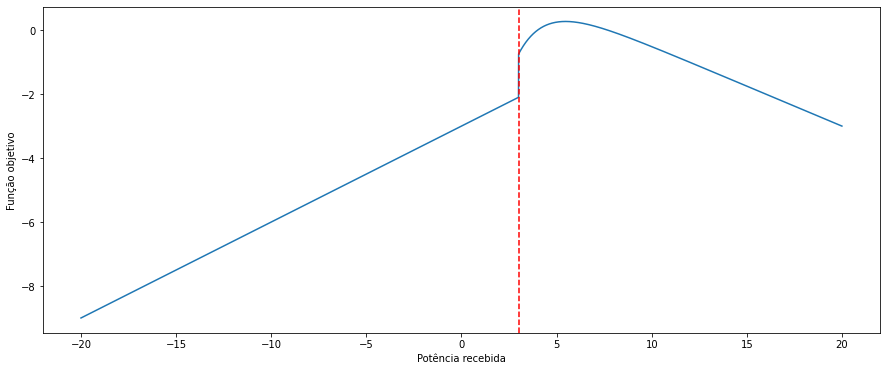

In [ ]:
lista = []
x = np.arange(-20,20,0.001)
for pot in x:
    fit = fitness_function([pot])
    lista.append(fit)

plt.figure(figsize=(15,6))
sns.lineplot(x=x, y=lista)
plt.axvline(3, ls='--', c='red')

plt.xlabel('Potência recebida')
plt.ylabel('Função objetivo')


In [ ]:
x[np.argmax(lista)]

5.471000000031129

# Aplicação

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
import sklearn.gaussian_process.kernels as kernels
import typing

In [ ]:
def np_rows_in(a, b):
    return (a == b[:, None]).all(axis=-1).any(axis=0)

In [ ]:
class Surrogate_GP():
    def __init__(self, 
                fitness_function: typing.Callable[[typing.Iterable], float],
                problem: str,
                espaco_estados: typing.Iterable,
                kernel = kernels.RBF(),
                noise_std: float = 0.001):
        
        assert problem in ['min', 'max'], 'problem parameter must be min or max'
        self.problem = problem
        self.espaco_estados = espaco_estados
        self.fitness_function = fitness_function
        self.kernel = kernel #Definição do kernel como RBF
        self.noise_std = noise_std #Desvio padrão do ruído presente nas amostras coletadas

        self.min_espaco = np.min(self.espaco_estados, axis=0)
        self.max_espaco = np.max(self.espaco_estados, axis=0)
        
        self.espaco_estados_norm = self.norm(self.espaco_estados)
    
    def norm(self, vetor):
        return (vetor - self.min_espaco)/(self.max_espaco - self.min_espaco)
    
    def desnorm(self, vetor):
        return (vetor*(self.max_espaco - self.min_espaco)) + self.min_espaco

    def plot_prev(self, mean_prediction, std_prediction):
        plt.figure(figsize=(15,6))

        #plt.plot(self.espaco_estados, Y, label=r"Real", linestyle="dotted", lw=3, c='orange') #Plotagem de f(X')
        plt.plot(self.espaco_estados, mean_prediction, label="Mean prediction") #Plotagem de E[f(X')]
        plt.fill_between( #Plotagem do intervalo de confiança considerando k(X,X') e o ruído nas amostras
            self.espaco_estados.ravel(),
            mean_prediction - 1.96 * std_prediction,
            mean_prediction + 1.96 * std_prediction,
            alpha=0.3,
            label=r"95% confidence interval",
        )

        plt.legend()
        plt.xlabel("$x$")
        plt.ylabel("$f(x)$")

        plt.tight_layout()
        plt.show()
    
    def plot_prev_safe(self, mean_prediction, std_prediction, beta, ind_safe_region, ind_potential_solutions, ind_expanders):
        plt.figure(figsize=(15,6))

        plt.plot(self.espaco_estados, mean_prediction, label="Mean prediction") #Plotagem de E[f(X')]
        plt.fill_between( #Plotagem do intervalo de confiança considerando k(X,X') e o ruído nas amostras
            self.espaco_estados.ravel(),
            mean_prediction - beta * std_prediction,
            mean_prediction + beta * std_prediction,
            alpha=0.3,
            label=r"95% confidence interval",
        )

        xmin, xmax, ymin, ymax = plt.axis()
        rectangle = plt.Rectangle((self.espaco_estados[ind_safe_region[0].item()].item(), ymin), 
                                   self.espaco_estados[ind_safe_region[-1].item()].item()- self.espaco_estados[ind_safe_region[0].item()].item(), 
                                   ymax-ymin, fc='green', ec="green", alpha=0.2, label='Safe region')

        plt.gca().add_patch(rectangle)

        for i, potential_solution in enumerate(self.espaco_estados[ind_potential_solutions]):
            if i == 0:
                plt.axvline(potential_solution, lw=0.5, c='pink', alpha=0.4, label='Potential solutions')
            else:
                plt.axvline(potential_solution, lw=0.5, c='pink', alpha=0.4)
        
        for i, expander in enumerate(self.espaco_estados[ind_expanders]):
            if i == 0:
                plt.axvline(expander, lw=0.5, c='gray', alpha=0.5, label='Expanders')
            else:
                plt.axvline(expander, lw=0.5, c='gray', alpha=0.5)

        plt.legend()
        plt.xlabel("$x$")
        plt.ylabel("$f(x)$")

        plt.tight_layout()
        plt.show()

    def prediction_based(self,
                         x_inicial: typing.Iterable, 
                         iteracoes: int,
                         random_state: int=0,
                         plot_final: bool=False,
                         plot_iteracao: bool=False):
        
        self.X_train = np.array(self.norm(x_inicial))
        Y_train = []
        for pot in x_inicial:
            Y_train.append(self.fitness_function(pot)) 

        for j in range(iteracoes):
            self.gpr = GaussianProcessRegressor(kernel=self.kernel, 
                                                alpha=self.noise_std**2, 
                                                random_state=random_state).fit(self.X_train, Y_train) #Implementação do GP
            
            #Previsão usando o dataset de teste
            mean_prediction, std_prediction = self.gpr.predict(self.espaco_estados_norm, 
                                                               return_std=True)
            mean_prediction, std_prediction = mean_prediction.ravel(), std_prediction.ravel()
            std_prediction = np.max(np.abs(mean_prediction))*std_prediction
            
            if self.problem == 'max':
                nova_amostra = np.array(self.espaco_estados_norm[mean_prediction.argmax()]).reshape(1,-1)
            if self.problem == 'min':
                nova_amostra = np.array(self.espaco_estados_norm[mean_prediction.argmin()]).reshape(1,-1)

            if nova_amostra.squeeze().tolist() in self.X_train.tolist():
                break

            self.X_train = np.concatenate((self.X_train, nova_amostra), axis=0)
            Y_train.append(self.fitness_function(self.desnorm(self.X_train[-1,:])))

            if plot_iteracao:
                self.plot_prev(mean_prediction, std_prediction)

        if self.problem == 'max':
            best_x = self.espaco_estados[np.argmax(mean_prediction)]
            best_y = np.max(mean_prediction)
        if self.problem == 'min':
            best_x = self.espaco_estados[np.argmin(mean_prediction)]
            best_y = np.min(mean_prediction)

        if plot_final:
            self.plot_prev(mean_prediction, std_prediction)

        return best_x, best_y, mean_prediction, std_prediction, j+1 

    def error_based(self,
                    x_inicial: typing.Iterable, 
                    iteracoes: int,
                    random_state: int=0,
                    plot_final: bool=False,
                    plot_iteracao: bool=False):
        
        self.X_train = np.array(self.norm(x_inicial))
        Y_train = []
        for pot in x_inicial:
            Y_train.append(self.fitness_function(pot)) 

        for j in range(iteracoes):
            self.gpr = GaussianProcessRegressor(kernel=self.kernel, 
                                                alpha=self.noise_std**2, 
                                                random_state=random_state).fit(self.X_train, Y_train) #Implementação do GP
            
            #Previsão usando o dataset de teste
            mean_prediction, std_prediction = self.gpr.predict(self.espaco_estados_norm, 
                                                               return_std=True)
            mean_prediction, std_prediction = mean_prediction.ravel(), std_prediction.ravel()
            std_prediction = np.max(np.abs(mean_prediction))*std_prediction

            nova_amostra = self.espaco_estados_norm[std_prediction.argmax()].reshape(1,-1)
            if nova_amostra.squeeze().tolist() in self.X_train.tolist():
                break
            
            self.X_train = np.concatenate((self.X_train, nova_amostra), axis=0)
            Y_train.append(self.fitness_function(self.desnorm(self.X_train[-1,:])))

            if plot_iteracao:
                self.plot_prev(mean_prediction, std_prediction)

        if self.problem == 'max':
            best_x = self.espaco_estados[np.argmax(mean_prediction)]
            best_y = np.max(mean_prediction)
        if self.problem == 'min':
            best_x = self.espaco_estados[np.argmin(mean_prediction)]
            best_y = np.min(mean_prediction)

        if plot_final:
            self.plot_prev(mean_prediction, std_prediction)

        return best_x, best_y, mean_prediction, std_prediction, j+1

    def interval_confidence_based(self,
                                  x_inicial: typing.Iterable, 
                                  iteracoes: int,
                                  alpha: float=1,
                                  random_state: int=0,
                                  plot_final: bool=False,
                                  plot_iteracao: bool=False):
                
        self.X_train = np.array(self.norm(x_inicial))
        Y_train = []
        for pot in x_inicial:
            Y_train.append(self.fitness_function(pot)) 

        for j in range(iteracoes):
            self.gpr = GaussianProcessRegressor(kernel=self.kernel, 
                                                alpha=self.noise_std**2, 
                                                random_state=random_state).fit(self.X_train, Y_train) #Implementação do GP
            
            #Previsão usando o dataset de teste
            mean_prediction, std_prediction = self.gpr.predict(self.espaco_estados_norm, 
                                                               return_std=True)
            mean_prediction, std_prediction = mean_prediction.ravel(), std_prediction.ravel()
            std_prediction = np.max(np.abs(mean_prediction))*std_prediction
            
            upper_confidence = mean_prediction + alpha*std_prediction #Maximização
            lower_confidence = mean_prediction - alpha*std_prediction #minimização
            
            
            if self.problem == 'max':
                nova_amostra = self.espaco_estados_norm[upper_confidence.argmax()].reshape(1,-1)
            if self.problem == 'min':
                nova_amostra = self.espaco_estados_norm[lower_confidence.argmin()].reshape(1,-1)
            
            if nova_amostra.squeeze().tolist() in self.X_train.tolist():
                break

            self.X_train = np.concatenate((self.X_train, nova_amostra), axis=0)
            Y_train.append(self.fitness_function(self.desnorm(self.X_train[-1,:])))

            if plot_iteracao:
                self.plot_prev(mean_prediction, std_prediction)

        if self.problem == 'max':
            best_x = self.espaco_estados[np.argmax(mean_prediction)]
            best_y = np.max(mean_prediction)
        if self.problem == 'min':
            best_x = self.espaco_estados[np.argmin(mean_prediction)]
            best_y = np.min(mean_prediction)

        if plot_final:
            self.plot_prev(mean_prediction, std_prediction)

        return best_x, best_y, mean_prediction, std_prediction, j+1 

    def prob_improve(self,
                     x_inicial: typing.Iterable, 
                     iteracoes: int,
                     random_state: int=0,
                     plot_final: bool=False,
                     plot_iteracao: bool=False):
                
        self.X_train = np.array(self.norm(x_inicial))
        Y_train = []
        gauss = stats.norm
        for pot in x_inicial:
            Y_train.append(self.fitness_function(pot)) 

        for j in range(iteracoes):
            self.gpr = GaussianProcessRegressor(kernel=self.kernel, 
                                                alpha=self.noise_std**2, 
                                                random_state=random_state).fit(self.X_train, Y_train) #Implementação do GP
            
            #Previsão usando o dataset de teste
            mean_prediction, std_prediction = self.gpr.predict(self.espaco_estados_norm, 
                                                               return_std=True)
            mean_prediction, std_prediction = mean_prediction.ravel(), std_prediction.ravel()
            std_prediction = np.max(np.abs(mean_prediction))*std_prediction

            if self.problem == 'max':
                y_max = np.max(Y_train)
                cdf_prob = 1 - gauss.cdf(y_max, mean_prediction, std_prediction)
            if self.problem == 'min':
                y_min = np.min(Y_train)
                cdf_prob = gauss.cdf(y_min, mean_prediction, std_prediction)

            cdf_prob[np_rows_in(self.espaco_estados_norm, self.X_train)] = 0
            nova_amostra = self.espaco_estados_norm[cdf_prob.argmax()].reshape(1,-1)
            if nova_amostra.squeeze().tolist() in self.X_train.tolist():
                break
            
            self.X_train = np.concatenate((self.X_train, nova_amostra), axis=0)
            Y_train.append(self.fitness_function(self.desnorm(self.X_train[-1,:])))

            if plot_iteracao:
                self.plot_prev(mean_prediction, std_prediction)

        if self.problem == 'max':
            best_x = self.espaco_estados[np.argmax(mean_prediction)]
            best_y = np.max(mean_prediction)
        if self.problem == 'min':
            best_x = self.espaco_estados[np.argmin(mean_prediction)]
            best_y = np.min(mean_prediction)

        if plot_final:
            self.plot_prev(mean_prediction, std_prediction)

        return best_x, best_y, mean_prediction, std_prediction, j+1 

    def expec_improve(self,
                     x_inicial: typing.Iterable, 
                     iteracoes: int,
                     random_state: int=0,
                     plot_final: bool=False,
                     plot_iteracao: bool=False):
                
        self.X_train = np.array(self.norm(x_inicial))
        Y_train = []
        gauss = stats.norm
        for pot in x_inicial:
            Y_train.append(self.fitness_function(pot)) 

        for j in range(iteracoes):
            self.gpr = GaussianProcessRegressor(kernel=self.kernel, 
                                                alpha=self.noise_std**2, 
                                                random_state=random_state).fit(self.X_train, Y_train) #Implementação do GP
            
            #Previsão usando o dataset de teste
            mean_prediction, std_prediction = self.gpr.predict(self.espaco_estados_norm, 
                                                               return_std=True)
            mean_prediction, std_prediction = mean_prediction.ravel(), std_prediction.ravel()
            std_prediction = np.max(np.abs(mean_prediction))*std_prediction

            if self.problem == 'max':
                y_max = np.max(Y_train)
                p_imp = 1-gauss.cdf(y_max, mean_prediction, std_prediction)
                p_ymax = gauss.pdf(y_max, mean_prediction, std_prediction)
                valor = -(y_max - mean_prediction)*p_imp + std_prediction*p_ymax
                valor = valor.clip(min=0)
                valor[np_rows_in(self.espaco_estados_norm, self.X_train)] = -0.1

            if self.problem == 'min':
                y_min = np.min(Y_train)
                p_imp = gauss.cdf(y_min, mean_prediction, std_prediction)
                p_ymin = gauss.pdf(y_min, mean_prediction, std_prediction)
                valor = (y_min - mean_prediction)*p_imp + std_prediction*p_ymin
                valor = valor.clip(min=0)
                valor[np_rows_in(self.espaco_estados_norm, self.X_train)] = -0.1

            nova_amostra = self.espaco_estados_norm[valor.argmax()].reshape(1,-1)
            if nova_amostra.squeeze().tolist() in self.X_train.tolist():
                break
            
            self.X_train = np.concatenate((self.X_train, nova_amostra), axis=0)
            Y_train.append(self.fitness_function(self.desnorm(self.X_train[-1,:])))

            if plot_iteracao:
                self.plot_prev(mean_prediction, std_prediction)

        if self.problem == 'max':
            best_x = self.espaco_estados[np.argmax(mean_prediction)]
            best_y = np.max(mean_prediction)
        if self.problem == 'min':
            best_x = self.espaco_estados[np.argmin(mean_prediction)]
            best_y = np.min(mean_prediction)

        if plot_final:
            self.plot_prev(mean_prediction, std_prediction)

        return best_x, best_y, mean_prediction, std_prediction, j+1

    def safe_opt(self,
                 x_inicial: typing.Iterable, 
                 iteracoes: int,
                 limite: float,
                 beta: float=20,
                 random_state: int=0,
                 plot_final: bool=False,
                 plot_iteracao: bool=False):
        

        self.X_train = np.array(self.norm(x_inicial))
        Y_train = []
        for x in x_inicial:
            Y_train.append(self.fitness_function(x)) 

        for j in range(iteracoes):
            self.gpr = GaussianProcessRegressor(kernel=self.kernel, 
                                                alpha=self.noise_std**2, 
                                                random_state=random_state).fit(self.X_train, Y_train) #Implementação do GP
            
            #Previsão usando o dataset de teste
            mean_prediction, std_prediction = self.gpr.predict(self.espaco_estados_norm, 
                                                               return_std=True)
            mean_prediction, std_prediction = mean_prediction.ravel(), std_prediction.ravel()
            std_prediction = np.max(np.abs(mean_prediction))*std_prediction
            
            upper_bound = mean_prediction + beta*std_prediction
            lower_bound = mean_prediction - beta*std_prediction
            valor = upper_bound - lower_bound
              
            if self.problem == 'max':
                ind_safe_region = np.where(lower_bound > limite)[0] #Cálculo da região segura  
                ind_potential_solutions = ind_safe_region[np.where(upper_bound[ind_safe_region] >= max(lower_bound))[0]]
            if self.problem == 'min':
                ind_safe_region = np.where(upper_bound < limite)[0] #Cálculo da região segura  
                ind_potential_solutions = ind_safe_region[np.where(lower_bound <= min(upper_bound))[0]]
            
            w_max = np.max(upper_bound[ind_potential_solutions] - lower_bound[ind_potential_solutions])
            ind_expanders = ind_safe_region[upper_bound[ind_safe_region] - lower_bound[ind_safe_region] > w_max]

            ind_solutions_expanders = np.unique(np.concatenate((ind_potential_solutions, ind_expanders)))
            valor = valor[ind_solutions_expanders]

            nova_amostra = self.espaco_estados_norm[ind_solutions_expanders[valor.argmax()]].reshape(1,-1)
            if nova_amostra.squeeze().tolist() in self.X_train.tolist():
                break
            
            self.X_train = np.concatenate((self.X_train, nova_amostra), axis=0)
            Y_train.append(self.fitness_function(self.desnorm(self.X_train[-1,:])))

            if plot_iteracao:
                self.plot_prev_safe(mean_prediction, std_prediction, beta, ind_safe_region, ind_potential_solutions, ind_expanders)

        if self.problem == 'max':
            best_x = self.espaco_estados[np.argmax(mean_prediction)]
            best_y = np.max(mean_prediction)
        if self.problem == 'min':
            best_x = self.espaco_estados[np.argmin(mean_prediction)]
            best_y = np.min(mean_prediction)

        if plot_final:
            self.plot_prev_safe(mean_prediction, std_prediction, beta, ind_safe_region, ind_potential_solutions, ind_expanders)

        return best_x, best_y, mean_prediction, std_prediction, j+1 

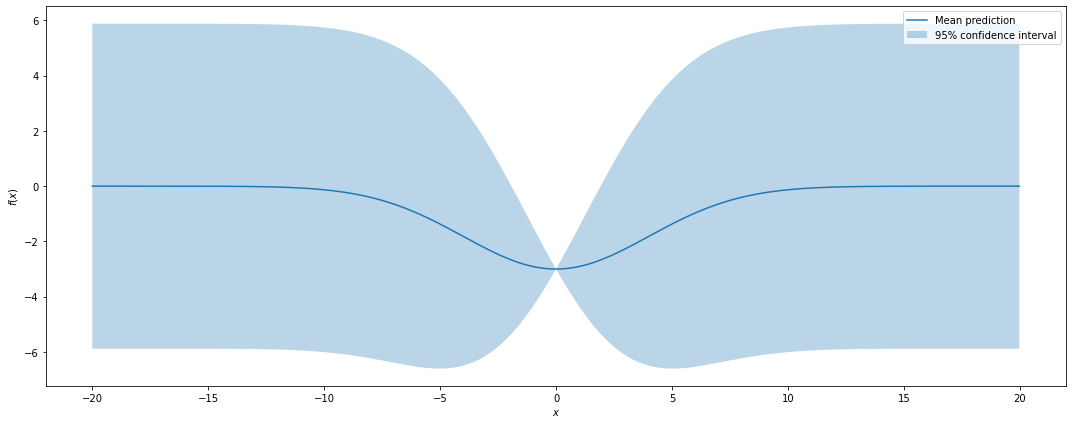

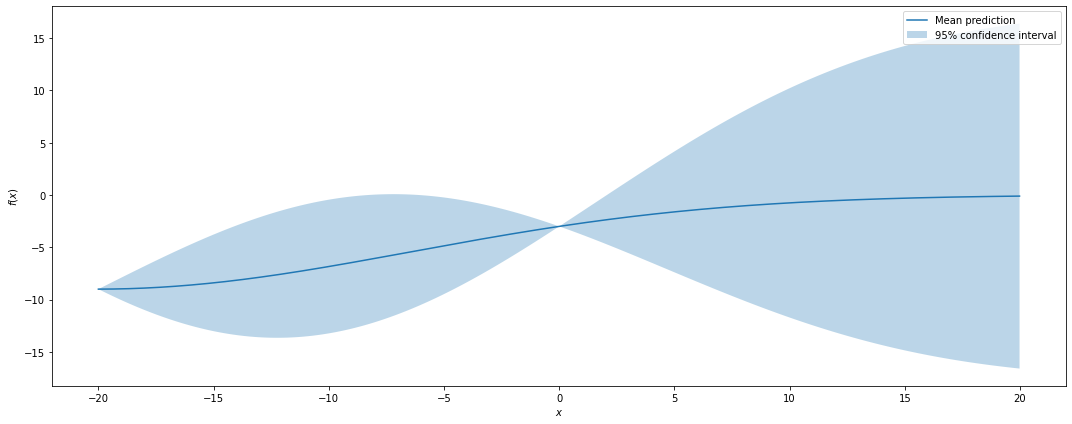

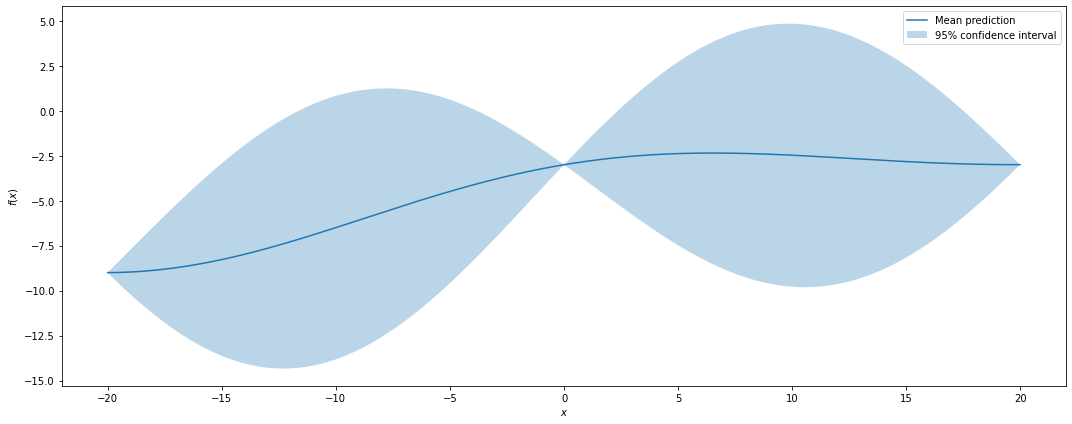

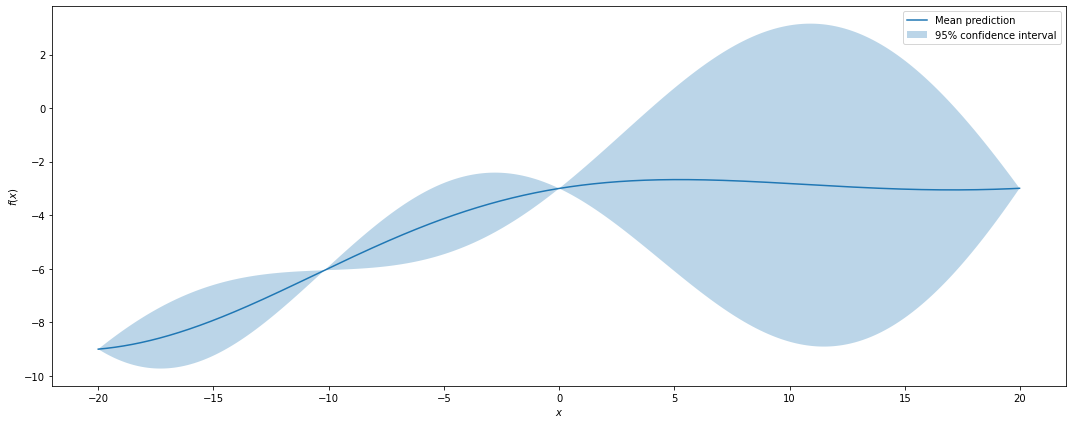

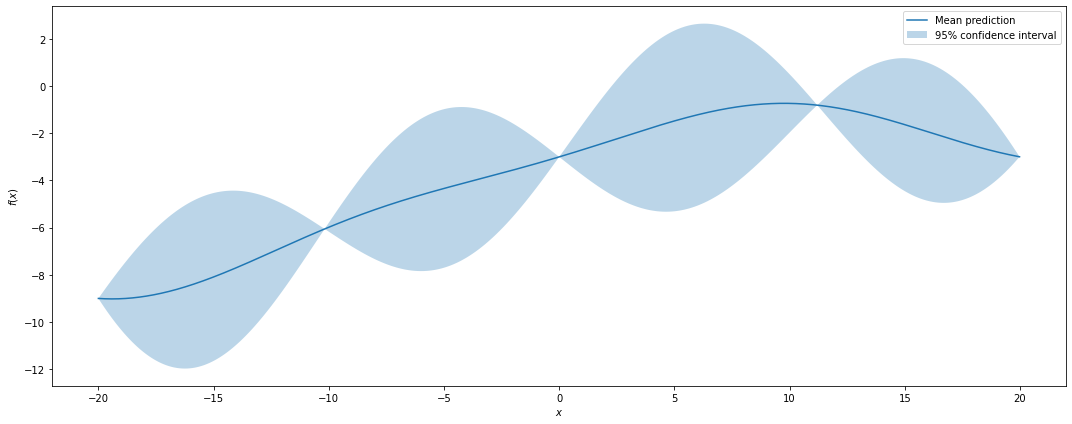

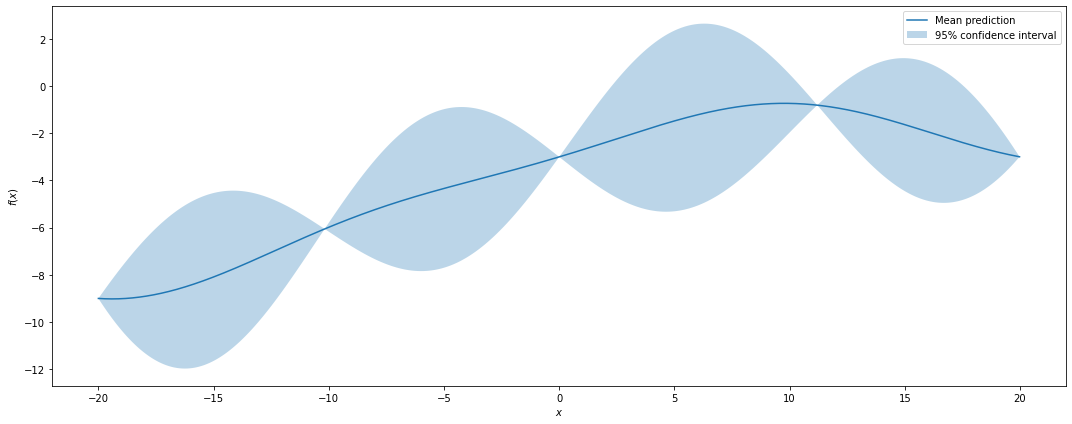

(array([9.76]),
 -0.7293931390988893,
 array([-8.99999991, -9.0013137 , -9.00258235, ..., -2.98760116,
        -2.99131977, -2.99501542]),
 array([0.00090199, 0.01481252, 0.02953978, ..., 0.02711933, 0.01360646,
        0.00090199]),
 5)

In [ ]:
espaco_estados = np.arange(-20, 20, 0.02).reshape(-1,1)
x = Surrogate_GP(fitness_function=fitness_function, 
                 problem='max',
                 espaco_estados=espaco_estados,
                 kernel=kernels.RBF(0.1),
                 noise_std=0.0001)

x.error_based(x_inicial=[[0]],
              iteracoes=5,
              #limite=-10,
              plot_iteracao=True,
              plot_final=True)

## Aplicação 2D

In [ ]:
import itertools

In [ ]:
def fitness_function(x):
    
    return -2*(x[0]+1)**2 - 5*(x[1]-3)**2 + 1*(x[2]-1)**2 + 10
    #return x[0]**2 + x[1]**2

In [ ]:
f = np.arange(-100, 100, 10)
f = np.array(list(itertools.product(f,f,f)))
f.shape

(8000, 3)

In [ ]:
x = Surrogate_GP(fitness_function=fitness_function, 
                 problem='max',
                 espaco_estados=f,
                 noise_std=0.001,
                 kernel=kernels.RBF(0.3))

x.safe_opt(x_inicial=[[0, 0, 0]],
              iteracoes=100,
              limite=-1e10,
              plot_iteracao=False,
              plot_final=False)

c:\Users\gabri\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


(array([   0,    0, -100]),
 9411.259878244535,
 array([-62435.85415635, -64356.07841035, -65595.71224608, ...,
        -50430.34949801, -48888.08372176, -46475.9297725 ]),
 array([  74.20608195,   74.20572622, 1829.47670375, ..., 6808.65699196,
        5496.30735424,   74.20771431]),
 100)

In [ ]:
g = []
for linha in f:
    g.append(fitness_function(linha))

g = np.array(g)

In [ ]:
g[np_rows_in(f, np.array([[0,0,-100]]))]

array([10164])

In [ ]:
f[np.argmax(g)]

array([   0,    0, -100])